In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import itertools
import pickle

from sklearn import metrics, datasets, ensemble
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.tree import _tree

import eli5
from eli5.sklearn import PermutationImportance

import shap

/home/topi/.virtualenvs/ml/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/topi/.virtualenvs/ml/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
model = pd.read_pickle('./data/Race_model_so.pkl')

X_train = pd.read_pickle('./data/Race_x_train.pkl')
y_train = pd.read_pickle('./data/Race_y_train_so.pkl')
X_test = pd.read_pickle('./data/Race_x_test.pkl')
y_test = pd.read_pickle('./data/Race_y_test_so.pkl')

In [3]:
# NxN-es feature mátrixot tölti fel
def fill_mx(matrix, feature_list, test_list):
    l = len(test_list)
    for i in range(l-1):
        for j in range(i+1,l):
            x = feature_list.index(test_list[i])
            y = feature_list.index(test_list[j])
            if (x==y): continue
            matrix[min(x,y)][max(x,y)] += 1

In [5]:
def recurse(node, list):
    if tree_.feature[node] != _tree.TREE_UNDEFINED:
        list.append(feature_name[node])
        recurse(tree_.children_left[node], list)
        recurse(tree_.children_right[node], list)
        del list[-1]
    else:
        fill_mx(matrix, feature_names, list)
                
feature_names = X_train.columns.values.tolist()
feature_list = []
matrix = np.array(np.zeros((len(feature_names),len(feature_names))))

#start recurse
for tree in model.estimators_:
    tree_ = tree.tree_
    feature_name = [
            feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
            for i in tree_.feature
        ]
    recurse(0, feature_list)

print(matrix.shape)
print(matrix)
matrix = matrix/(np.max(matrix))
print('\nnormalized:\n',matrix)

(128, 128)
[[  0. 113. 278. ... 220. 734. 275.]
 [  0.   0. 125. ... 154. 569.  99.]
 [  0.   0.   0. ... 162. 702. 250.]
 ...
 [  0.   0.   0. ...   0. 773. 282.]
 [  0.   0.   0. ...   0.   0. 541.]
 [  0.   0.   0. ...   0.   0.   0.]]

normalized:
 [[0.         0.00820505 0.02018588 ... 0.01597444 0.05329654 0.01996805]
 [0.         0.         0.00907639 ... 0.01118211 0.04131571 0.0071885 ]
 [0.         0.         0.         ... 0.011763   0.05097299 0.01815277]
 ...
 [0.         0.         0.         ... 0.         0.05612838 0.02047633]
 [0.         0.         0.         ... 0.         0.         0.0392826 ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [6]:
import pandas as pd
df = pd.DataFrame(matrix, index=feature_names, columns=feature_names)
pairs = df.stack().sort_values(ascending=False)
pairs[0:20]

f81  f86     1.000000
f55  f81     0.854197
f50  f81     0.848751
f37  f81     0.825443
f81  f108    0.788266
f48  f81     0.750799
f20  f81     0.723787
f81  f83     0.692637
f55  f86     0.671072
f86  f108    0.667949
f50  f86     0.655243
f58  f81     0.647328
f71  f86     0.639195
f37  f55     0.637888
f55  f83     0.630046
f69  f81     0.627578
f37  f50     0.619663
f71  f81     0.607247
f20  f50     0.591708
f37  f86     0.588368
dtype: float64

In [7]:
# Feature importance dataframe
ms_imp_df = pd.DataFrame({'feature': X_train.columns.values,
                       'importance': model.feature_importances_})
 
# Reorder by importance
ms_ordered_df = ms_imp_df.sort_values(by='importance', ascending=False)
ms_ordered_df.head(n=15)

,feature,importance
80,f81,0.055318
49,f50,0.038943
85,f86,0.036639
36,f37,0.032951
82,f83,0.029563
97,f98,0.028870
19,f20,0.027356
54,f55,0.027342
47,f48,0.025644
68,f69,0.023100


<AxesSubplot:>

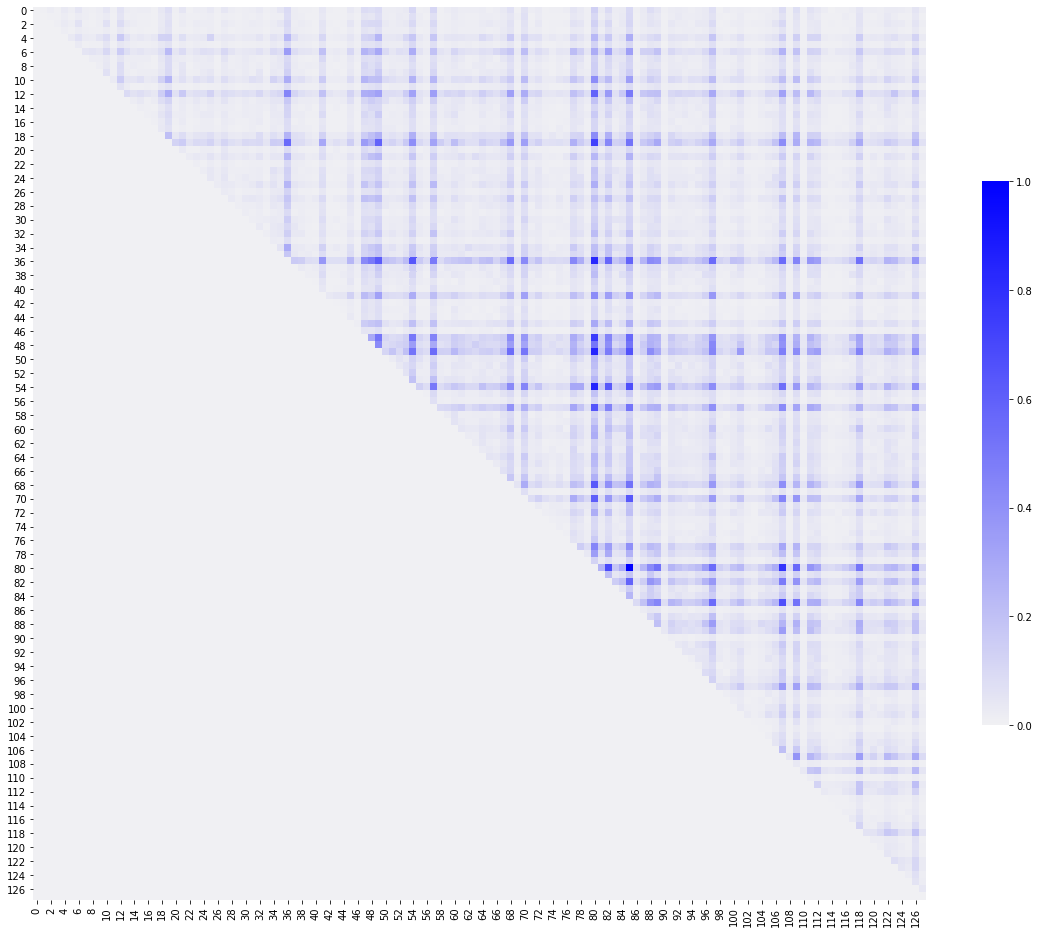

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.subplots(figsize=(20, 20))
cmap = sns.color_palette("light:b", as_cmap=True)
sns.heatmap(matrix, cmap=cmap, square=True, cbar_kws={"shrink": .5})

In [9]:
from pyvis.network import Network
import networkx as nx 

g = Network(height='750px', width='100%', bgcolor='#222222', font_color='white', notebook=True)

g.barnes_hut()
# add nodes
g.add_nodes(feature_names)

# edges from matrix
for i in range(len(feature_names)-1):
    for j in range(i+1,len(feature_names)):
        g.add_edge(feature_names[i], feature_names[j], value=matrix[i][j])
            
g.show("embedding_network.html")